## NOTE
Currently this bot does not train well and eats memory like crazy RUN AT YOU OWN RISK or if you see anything blatently wrong or improvments feel free to play with it or let Braeden and Owen know 

## Model
Regression model using keras. Currently setup in a very default way with little optimizations. 

In [17]:
from tensorflow import keras
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

model = keras.Sequential([
	keras.Input(shape=(166,)),
	keras.layers.Dense(128, kernel_regularizer=keras.regularizers.L1(0.00001) ,activation='relu'),
	keras.layers.Dense(1,)
])


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

## Setting the exploration rate
The exploration rate is defined as the chance of randomly making a move instead of relying on the prediction of the model. The pause is for when running the train function as it will clear the graph too fast to see if its right.

In [23]:
import time
def get_exp_rate(num_games, start = 1, stop = 0.5, scale = 0.5):
    exploration_rates = np.linspace(start, stop, num_games)**scale
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_xlabel('Number of games played')
    ax.set_ylabel('Exploration rate')
    ax.plot(np.linspace(1, num_games, num_games), exploration_rates)
    ax.set_title('Exploration rate as the number of games played increases')
    plt.show()
    time.sleep(3)
    return exploration_rates

## Model interactions
These are the functions that actually play games and train the model.

In [25]:
import chess
import numpy as np
import time
from IPython.display import clear_output
from chessbot.chessbot import ChessBot

def get_piece_values(board):
	reward = 0
	piece_map = board.piece_map()
	for _, piece in piece_map.items():
		color = 1 if piece.color else -1


		if piece.piece_type == chess.ROOK:
			reward += 5*color
		elif piece.piece_type == chess.BISHOP or piece.piece_type == chess.KNIGHT:
			reward += 3*color
		elif piece.piece_type == chess.QUEEN:
			reward += 8*color
		elif piece.piece_type == chess.PAWN:
			reward += 1*color
		r = reward/38 if (abs(reward/38))<1 else (reward/abs(reward))
	return r



def play_game_and_learn(model, games_per_train = 1, exploration_rate=0.0, should_visualise=False):
	results = np.array([0,0,0])
	Xs = None
	ys = None
	for i in range(games_per_train):
		white = ChessBot(model, chess.WHITE, exploration_rate)
		black = ChessBot(model, chess.BLACK, exploration_rate)
		board = chess.Board()
		if should_visualise:
			display(board)

		reward = []
		while not board.is_game_over(claim_draw=True):
			board.push(black.move(board) if board.turn == chess.BLACK else white.move(board))
			reward.append(get_piece_values(board))
			if should_visualise:
				clear_output(wait=True)
				display(board)
				time.sleep(0.1)

		result = board.outcome(claim_draw=True).result()

		# If the game was not a draw train the model
		#if result == '1/2-1/2':
			#return result, None, None
		
		X = np.empty((len(white.moves_made) + len(black.moves_made), len(white.moves_made[0])))
		y = np.array(reward)

		# Blend the moves into a single array with alternating elements
		X[::2] = white.moves_made
		X[1::2] = black.moves_made

		# Set the label for the last move to 1, representing a winning move, then
		# discount the rest as they led to a win but should not be rewarded as heavily
		discount_factor = 0.98
		#y_reversed_indices = np.linspace(len(y) - 1, 0, num=len(y))
		#y = 1 * discount_factor**y_reversed_indices

		if result != '1/2-1/2':
			# If black won flip the labels since our model evaluates white's position
			for i in range(5,0,-1):
				if result == '1-0':
					y[len(y)-i] = 1*discount_factor**(i-1)
				elif result == '0-1':
					y[len(y)-i] = -1*discount_factor**(i-1)

		# Scale the labels to be between 0 and 1 instead of -1 and 1
		
		y = (y + 1) / 2

		if X is not None and y is not None:
			if Xs is None:
				Xs = X
				ys = y
			else:
				Xs = np.concatenate((Xs, X))
				ys = np.concatenate((ys, y))
		
		if result == '1-0':
			results[0] += 1
		if result == '0-1':
			results[1] += 1
		if result == '1/2-1/2':
			results[2] += 1
	if not np.isnan(Xs).any():
		model.fit(Xs, ys, shuffle=False)
	else:
		print("Not training because of NAN data")

	return results, Xs, ys

## Training the model
The model will be trained by playing against itself. The train function allows control over most training parameter all in one place. The last cell loops train to with simple param varrying to provide more controll to how the model is trained. This also allow you to pause in the middle of training easier and with less lost data. 

In [26]:
# Initialize objects to track game results (only run this cell when you want to reset results)
def train(save_directory, start, stop, scale, num_games = 5000, paused_on = 0, games_per_fit = 2):
    exploration_rates = get_exp_rate(num_games, start, stop, scale)
    X_all = None
    y_all = None
    results = np.array([0,0,0])

    for i in range(paused_on, num_games, games_per_fit):
        clear_output(wait=True)
        
        print(f'White wins: {results[0]}, Black wins: {results[1]}, Draws: {results[2]}')
        print(f'Game {i}/{num_games} (exploration rate: {exploration_rates[i]:.2f})')

        result, X, y = play_game_and_learn(model, games_per_fit, exploration_rate=exploration_rates[i])
        results += result

        if X is not None and y is not None:
            if X_all is None:
                X_all = X
                y_all = y
            else:
                X_all = np.concatenate((X_all, X))
                y_all = np.concatenate((y_all, y))

        

    model.save(f'{save_directory}{i+games_per_fit}_games_model')
    np.savez_compressed(f'{save_directory}{i+games_per_fit}_games_data.npz', X=X_all, y=y_all)
    print(f'###Final tally###\nWhite wins: {results[0]}, Black wins: {results[1]}, Draws: {results[2]}')

In [ ]:
#Must change this up before running
for i in range(4, 10):
    discount = 0.9
    num_games = 5000+ (1000*(i+1))
    paused_on = 5000+(i*1000)
    scale = 2
    start = 0.9*discount**i
    stop = 0.5*discount**i
    train('chessbot_weights/', start, stop, scale, num_games, paused_on)

## Why not watch a game after all that training?
Plays a game with the current model to watch how its doing.

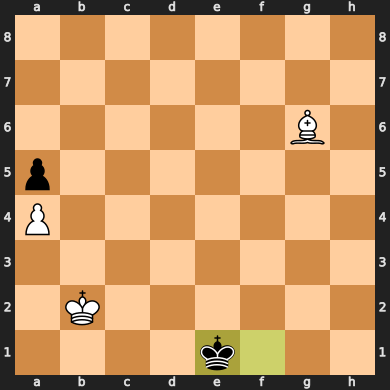

13/13 [==============================] - 0s 1ms/step - loss: 1.4384
Game result: [0 0 1]


In [29]:
result = play_game_and_learn(model, should_visualise=True)
print(f'Game result: {result[0]}')